# A users' guide to apply the presence-only joint distribution framework for single species distributions
#### Juan M. Escamilla Mólgora,
#### j.escamillamolgora@lancaster.ac.uk


> ## Summary
This document is a guide to use the models described in the paper: *A joint distribution framework to improve presence-only species distribution models by exploiting opportunistic surveys* (EscamillaMolgora,2021) for modelling species distributions with presence-only data.

## Introduction
The presented framework proposes three bayesian models for inferring single species distributions using solely observations of species occurrences (i.e. presence-only data).
The fundamental idea of the framework is that the observed occurrences ($Y$) are determined not only by the environmental conditions (niche) suitable for the species to thrive but also accounts for the bias in which these observations were collected (i.e. sampling effort). As such, the occurrences are specified as realisations of a join process composed of environmental conditions ($P_Y$) and sampling effort ($P_X$). These two components are explicitly defined with a model-based approach (cite:Diggle2002) to specify two types of covariates, one for $P_X$ and other for $P_Y$.
Both processes are specified as mixed models. That is, they are composed of  a fixed effect (i.e. $E(P_X) = g(d_X;\beta_X)$ and $E(P_Y) = g(d_Y;\beta_Y)$) and a random effect that models the variation between observations across space. For the purposes of this example (and the presented results in the manuscript) we consider $g(d_X;\beta_X)$ to be linear, that is: $g(d_X;\beta_X) = \beta_X^t d_X$, where $d_X$ is the vector of covariates associated to a given observation. For a clear description of the model refer to the manuscript and, specifically, to the supplementary materials.

The dependencies between processes $P_X$ and $P_Y$ are specified in terms of the covariance between all observations. That is, by their random effects; $R_X$ and $R_Y$ respectively. We proposed three forms to model these dependencies. Model I assumes $R_X$ and $R_Y$ are independent. Model II assumes that $R_X = R_Y$ and Model III assumes both random effects are correlated. The three models specify a conditional autoregressive (CAR) (Besag,1974) model for defining the spatial random effect. Therefore, this framework is only suited for data aggregated in areas tilled over a region (i.e. spatial lattices).

In the following sections we will apply models I, II and III in the *R* programming language using the package CARBayes (Lee,2013). The data used was obtained from GBIF using the dataset (gbifmexdata). This document is intended to serve as a guide for modelling species distributions using the aforementioned framework. For further reference of the Bayesian methodologies, diagnoses and deeper analysis of lattice-based models refer to (Lee,2013;Rue,2005)

We begin by first assigining the working directory.


In [1]:
setwd('/main/app/external_plugins/biospytial_rwrapper/CAR-1SDM/')
#source('R/preprocess_data.R')

## Loading data and necessary libraries
- *CARBayes* is a CAR implementation developed by (Lee,2013). We can use this library with adequate data transformation to apply models I, II and III.

In [2]:
setwd("R")
library(CARBayes)


Loading required package: MASS

Loading required package: Rcpp

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



- Additionaly, some libraries for data handling and loading numpy arrays.





In [3]:
library(dplyr)
library(purrr)
library(reticulate)


Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




### Loading the *choosing principle* functions
These are functions that define the presence, relative absences and missing observations.

In [4]:
source("ChoosingPrinciples.R")

## Read the adjancency matrix of the spatial lattice
The spatial lattice is represented as an adjacency matrix obtained by another sofware. 
However you could generate this matrix of any given spatial vector format (e.g. ESRI Shapefile) using the function 'combine.data.shapefile' provided by *CARBayes*. Refer to the https://cran.r-project.org/web/packages/CARBayes/CARBayes.pdf (CARBayes documentation).


In [5]:
# Import adjancency matrix generated from region
mat_filename = "../data/training_data_sample_puebla_p9_abies_pinophyta_adjmat.npy"
# The adjacency matrix is saved as a numpy object. We need load it appropiately
# Use numpy functions
np <- import("numpy")
M <- np$load(mat_filename)

## Importing main dataframe
We will first load the dataframe as 'TDF' and then sort the rows according to their 'cell_ids' to match that of the adjancency matrix M.


In [6]:
TDF = read.csv("../data/training_data_sample_puebla_p9_abies_pinophyta.csv")
## Uncomment this to load the birds example
#TDF = read.csv("../data/training_data_sample_puebla_p9_tyrannidae_birds.csv")
## Order it according to the id of the cell
TDF = TDF[order(TDF$cell_ids),]
# Convert the columns to numeric

## Beware, older implementations of as.numeric function turns strings to (apparently) random numeric values
TDF = mutate_at(TDF,vars(Dist.to.road_m,Elevation_m,
                         MaxTemp_m,MeanTemp_m,
                         MinTemp_m,Population_m,
                         Precipitation_m,
                         SolarRadiation_m,
                         VaporPres_m,
                         WindSp_m),na_if,"N.A.")



TDF = mutate_at(TDF,vars(Dist.to.road_m,Elevation_m,
                         MaxTemp_m,MeanTemp_m,
                         MinTemp_m,Population_m,
                         Precipitation_m,
                         SolarRadiation_m,
                         VaporPres_m,
                         WindSp_m),as.numeric)

# Remove unnecessary symbols in variable names
names(TDF) = lapply(names(TDF),function(x) gsub("_","",x))
names(TDF) = lapply(names(TDF),function(x) gsub("\\.","",x))


## Generating relative absences with  the *choosing principle*
There are two treatments for the assigning missing data, treatment I that assumes missing data in both processes and treatment II that assigns missing data only to the sampling effort. This later treatment has less uncertainty but the assumption of absences is strong. Uncomment the code to use the other treatment.


In [7]:
# Change the name of a column that for some reason is called the same
names(TDF)[23] <- 'code_id2'

## Treatment I, missing values in X and Y, comment this if using treatment II
DataFrame = TDF %>% rowwise() %>%
              mutate(sample=pseudo_absence_naive(Plantae,LUCA),
                     species=pseudo_absence_naive(Pinophyta,Plantae))

## Uncomment this for treatment II (i.e. missing values only in X)
#DataFrame = TDF %>% rowwise() %>%
#            mutate(sample=pseudo_absence_naive(Plantae,LUCA),
#                   species=pseudo_absence_trivial(Pinophyta,Plantae))

## Uncomment this if you want to assume that all missing data are absences
## i.e. remove NAs
#
## Remove entries in the adjacency matrix that correspond to missing data
#rr <- DataFrame %>%
#    filter(!is.na(species) & !is.na(sample))
#
#sam_idx_nan <- which(is.na(DataFrame$sample))
#
#M = M[-c(sam_idx_nan),-c(sam_idx_nan)]

## Remove missig data in DataFrame
#DataFrame = TDF %>% rowwise() %>%
#  mutate(sample=pseudo_absence_trivial(Plantae,LUCA),
#         species=pseudo_absence_trivial(Pinophyta,Plantae))
#+end_src


## Preprocess adjancency matrix $M$
There is a caveat, though. The CAR model works for connected regions only. That is, when the adjacency matrix corresponds to a connected graph. Blocks of cells that are not connected to each other are called islands and are considered independent. That is, a new model should be run for each block of disconnected cells.

That is, we need to identify the blocks of isolated cells and remove them from the adjacency matrix. On order to comply with the dimension of the associate covariate (design) matrix we need to remove the associated rows (entries) corresponding to the isolated cells.


In [8]:
## Remove entries with zero neighbours (adjacency matrix)
### Calculates number of neighbours in D (sum)
D = apply(M,MARGIN = 1,sum)
### get index with 0 neighbours
idx = which(D == 0)

### select cells with no neighbours
cell_with_no_neighbour = TDF$cellids[idx]
## Remove island for TDF
TDF <- TDF[-c(idx),]
## Erase idx for M and for TDF
M_bis = M[-c(idx),-c(idx)]

## remove rows that have no neighbours (islands)
DataFrame <- DataFrame[-c(idx),]

n <- dim(M_bis)[1]
trials <- rep(1,n)




As the current implementation of CARBayes does not allow missing values in the covariates we will perform a naive imputation of missing values on each column of interest (i.e covariates associated with the models' formulas).


In [9]:
## Replace missing values with mean, Of course we could do this using other more fancy method
covs2work = c("Disttoroadm","Populationm","Elevationm","Precipitationm","MeanTempm")
for(i in covs2work){
    DataFrame[,i][is.na(DataFrame[,i])] <- mean(DataFrame[,i][!is.na(DataFrame[,i])],na.rm=TRUE)
}

# Model I

This model assumes that the ecological suitability distribution ($Y$) and sampling effort $X$ process are independent. The structure of the model is visualised as a directed acyclic graph (DAG) in the figure below.  For a detail explanation of the model refer to the supplementary materials of the manuscript.

<img src="m1.png" alt="model I"  width="400px">


In [10]:
## Load function for Model I
source("joint.binomial.bymCARModel1.R")


A brief data exploration shows the number of relative absences and presences (npresence_0,npresece_1) in the "presences" process $Y$, the in the sampling process $X$  (i.e. nsample_0 and nsample_1, respectively). Missed data (no observations) are shown as n_miss_presence and n_miss_sample. for $Y$ and $X$ respectively.



In [11]:
ntot = length(DataFrame$sample)
npresence_1 = length(na.omit(DataFrame$species[DataFrame$species == 1])) / ntot*100
nsample_1 = length(na.omit(DataFrame$sample[DataFrame$sample == 1]))/ntot*100
npresence_0 = length(na.omit(DataFrame$species[DataFrame$species == 0]))/ntot*100
nsample_0 = length(na.omit(DataFrame$sample[DataFrame$sample == 0]))/ntot*100
n_miss_presence = sum(is.na(DataFrame$species))/ntot*100
n_miss_sample = sum(is.na(DataFrame$sample))/ntot*100
cbind(npresence_0,npresence_1,nsample_0,nsample_1,n_miss_presence,n_miss_sample)

npresence_0,npresence_1,nsample_0,nsample_1,n_miss_presence,n_miss_sample
63.02956,8.399015,10.59113,71.42857,28.57143,17.9803


### Running the model
We begin by defining the formulas for the sampling effort (formula_sample) and the environmental niche (formula_presence).
As we are dealing with only presence-absence realisations, we define a bernoulli process. That is, a binomial distribution with $k=1$.
This can be specified with a 'trials' vector built on only ones.


In [12]:
formula_sample=sample~Disttoroadm+Populationm
formula_presence=species~Elevationm+MeanTempm
n <- nrow(TDF)
trials <- rep(1,n)



We define the running settings for sampling the posterior distribution. In this case we specify 1,000 iterations after burnin (i.e. initialisation to reach stationarity of the Markov chain) of 70,000. To reduce hoarding data in memory we choose a thinning of 10. The postburnin parameter defines the number of iterations after burnin for each process but before saving the final sample of 1,000 iterations. Postburnin defines and extra burn-in iterations.


In [13]:

## To example, use higher sampling for real applications.
n.sample = 10000                                                                               
burnin=10000
thin = 10
postburnin = burnin + 1000

In [14]:
model1  <- joint.binomial.bymCARModel1(formula_S = formula_sample,
                                        formula_P = formula_presence,
                                        n.sample=n.sample,
                                        data = DataFrame,
                                        burnin=burnin,
                                        postburnin=postburnin,
                                        thin=thin,
                                    verbose=TRUE)

Setting up the model.
Performing burnin period for Sample Effort Model 
  |======================================================================| 100%
Summarising results.
Finished in  41.3 seconds.
Setting up the model.
Performing burnin period for Presence model 
  |======================================================================| 100%
Summarising results.
Finished in  40.1 seconds.
Sampling from the joint model 1000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
[1] "Compiling summary for S process"
[1] "Compiling summary for the P process"


In model I, the processes $S$ (sample) and $P$ (environment) are independent. The object model1 contains these independent components stored as attributes S and P respectively. To inspect the posterior summary statistics we can use the attribute summary.results on each process. 

In [15]:
model1$P$summary.results

,Median,2.5%,97.5%,n.sample,% accept,n.effective,Geweke.diag
(Intercept),-6.5212,-16.2872,0.8302,1000,53.3,6.1,-2.3
Elevationm,0.0019,0.0002,0.0037,1000,53.3,5.8,0.4
MeanTempm,0.0188,-0.2874,0.3005,1000,53.3,7.8,0.6
tau2,8.1528,4.1537,12.8222,1000,100.0,6.9,1.3
sigma2,0.0343,0.0103,0.0611,1000,100.0,5.8,-6.8


In [16]:
model1$S$summary.results

,Median,2.5%,97.5%,n.sample,% accept,n.effective,Geweke.diag
(Intercept),1.7029,1.7029,1.7029,1000,0,0.0,NaN
Disttoroadm,0.0000,0.0000,0.0000,1000,0,0.0,NaN
Populationm,0.0034,0.0034,0.0034,1000,0,0.0,NaN
tau2,3.4330,2.1717,5.5387,1000,100,11.3,-0.9
sigma2,0.4846,0.2854,0.8422,1000,100,10.3,-0.4


### Display modelfit object for both models

In [17]:
model1$summary.results

DIC           p.d          WAIC           p.w          LMPL 
    3630.7541      756.7261     3684.9768      663.6253    -1884.0931 
loglikelihood 
   -1058.6509

In [18]:
model1$P$modelfit

DIC           p.d          WAIC           p.w          LMPL 
    1490.5567      350.4807     1520.1263      304.8776     -784.5182 
loglikelihood 
    -394.7977

### Convergence of the Markov chain by visual inspection
Using traceplots

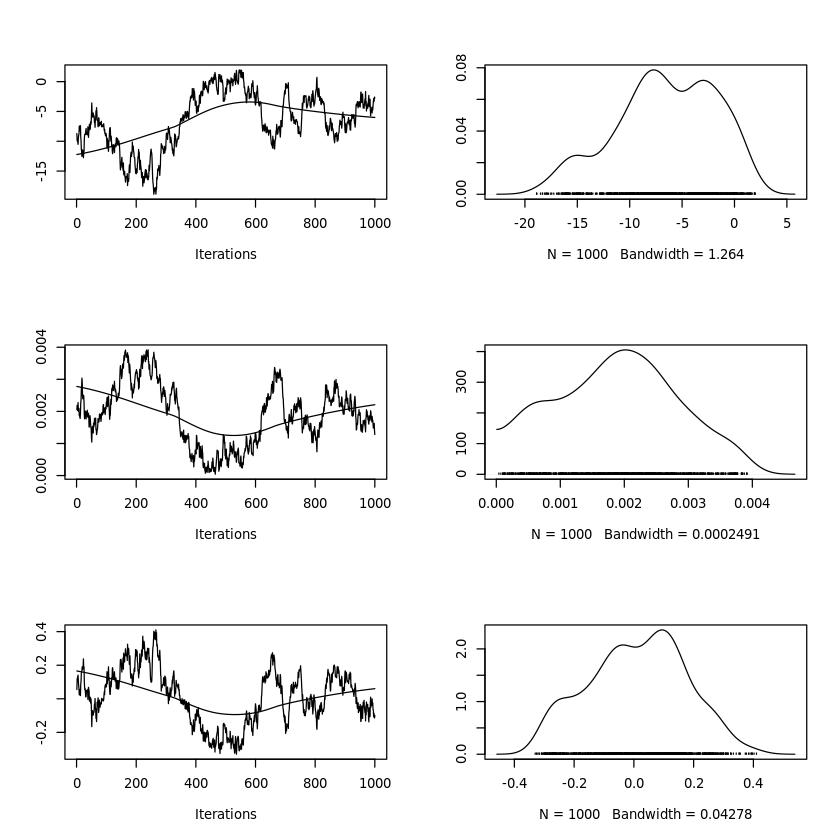

In [19]:
library(coda)
params.samples <- mcmc.list(model1$P$samples$beta)
plot(params.samples)

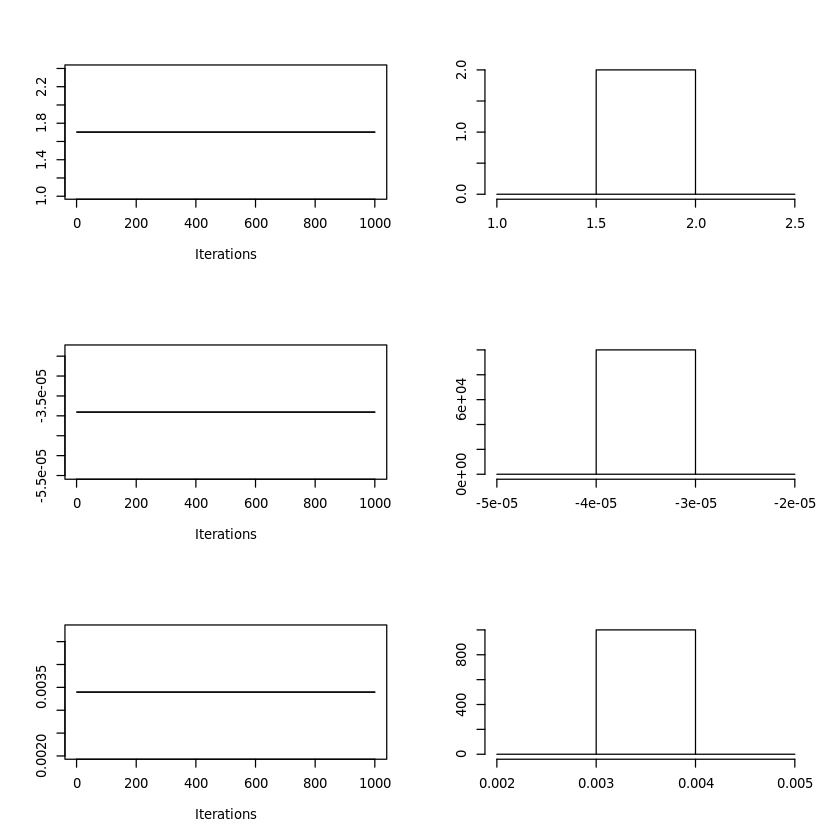

In [20]:
## For the sample process
params.samples <- mcmc.list(model1$S$samples$beta)
plot(params.samples)

# Model II

## Running the model
To run the model we first need to transform the data, specifically, the covariates matrix (i.e. design matrix). The transformation allows the fitting of specific covariates for each process (i.e. an environmental set of covariates and another set for the sampling effort).

To do this, we stack the design matrices of $S$ and $P$ and extend the number of columns to the sum of both processes.
That is, the number of columns of the resulting matrix is the sum of the columns of $P$ and $S$ (not counting the response variables).

We begin by selecting the covariates for each process following a standard formula syntax (one formula per process).

<img src="m2.png" alt="model II"  width="400px">


In [21]:
formula_sample =  sample ~ Disttoroadm + Populationm
formula_presence = species ~ Elevationm + Precipitationm


## Build dataframes, S <- Sample, P <- Presence
S <- model.frame(formula_sample, DataFrame,na.action='na.pass')
P <- model.frame(formula_presence, DataFrame,na.action='na.pass')

## Split response variables (lefthand side) and covariates (righthand side) from the design matrix
SX <- select(S, -c(1))
PX <- select(P, -c(1))
Sy <- select(S, c(1))
Py <- select(P, c(1))

## Assign names to columns
names(Sy) <- 'response'
names(Py) <- names(Sy)

## Stack both processes into same dataframe
## First the responses (Y) will be concatenated by row.
Y = rbind(Sy,Py)


To join both sets of covariates (SX and PX) into the stacked design matrix, we need to join the columns of SX and PX. As there's no information of environmental variables for process S and, viceversa, no information of the sampling covariates for process P, we assign 0 to these elements.

For doing this, we first define two 2x2 matrices and perform the kronnecker product to generate a block diagonal design matrix to be used as the covariates of the stacked design matrix.

In [22]:

T1 <- matrix(rep(0,4), ncol = 2)
T2 <- matrix(rep(0,4), ncol = 2)
T1[1,1] <- 1
T2[2,2] <- 1

## Perform Kronnecker with different covariates (Block diagonal)
X <- data.frame((T1 %x% as.matrix(SX)) + (T2 %x% as.matrix(PX)))
names(X) <- c(names(SX),names(PX))

## Lastly, we bind the stacked response variable with the stacked covariance matrix.
SDM <- cbind(Y,X)


### Defining other necessary arguments


In [23]:
## Get number of elements in the lattice, 
nK <- dim(M_bis)[1]

## make sequence vector for id.area
## This is possible because the rows in adjacency matrix M_bis preserve the order of each element in the design matrix.
ida <- data.frame(seq(nK))
idarea <- unlist(rbind(ida,ida))
## Assign values for the unstructured random effect (Zx, Zy).
## In this case, all elements of S share the same random effect Zx. 
## Similarly, all elements of P share the same random effect Zy.
## This is done with 
Zx <- rep(x = 1,times = nK)
Zy <- rep(x = 2,times = nK)
## Stack Zx and Zy to create a vector of labels used to define 
## the unstructured random effect.
indre <- c(Zx,Zy)


## Running the model

In [24]:
#formula_sample =  sample ~ Disttoroadm + Populationm
#formula_presence = species ~ Elevationm + Precipitationm
formula <- response ~ Disttoroadm + Populationm + Elevationm + Precipitationm
ind.re = c(rep(1,nK),rep(2,nK))

ntot <- dim(SDM)[1]
trials <- rep(1,ntot)
## Toy example, increase sampling and burnin size significantly for real applications.
burnin = 100
n.sample = 120
thin = 5


model2 <- S.CARmultilevel(formula,family = 'binomial',
                          trials=as.numeric(trials),
                          W=M_bis,
                          ind.area=idarea,
                          #ind.re=factor(idarea),
                          ind.re = factor(ind.re),
                          rho=1,
                          burnin=burnin,
                          n.sample=n.sample,
                          data=SDM)

Setting up the model.
Generating 20 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
Summarising results.
Finished in  1.9 seconds.


In [25]:
model2$summary.results

,Median,2.5%,97.5%,n.sample,% accept,n.effective,Geweke.diag
(Intercept),0.5262,0.5262,0.5262,20,0,0,NaN
Disttoroadm,0.0001,0.0001,0.0001,20,0,0,NaN
Populationm,0.0064,0.0064,0.0064,20,0,0,NaN
Elevationm,-0.0002,-0.0002,-0.0002,20,0,0,NaN
Precipitationm,-0.0221,-0.0221,-0.0221,20,0,0,NaN
tau2,2.9336,2.8369,3.0991,20,100,20,-0.7
sigma2,0.8124,0.2411,3.9173,20,100,20,-1.0
rho,1.0000,1.0000,1.0000,NA,NA,NA,NA


# Model III
This model assumes that processes $S$ and $P$ are correlated to each other. Both of them have a specific Gaussian Markov random field and these two spatial structures are correlated. The correlated spatial structure follows a multivariate CAR specification (cite:kavanagh2016,Lee2013). The structure of the model is visualised as a directed acyclic graph (DAG) in the figure [[ref:fig:M3]].  For a detail explanation of the model refer to the supplementary materials of the manuscript.
 $$ [P , S ] = [P | GMRF_p] [ S | GMRF_s] $$
 



<img src="m3.png" alt="model III"  width="400px">


## Running the model
Applying this model is straight forward. We only need to define an appropriate formula object.

In [26]:
formula <- cbind(species,sample) ~ Elevationm + Precipitationm + Disttoroadm + Populationm

In [27]:
## Get number areal elements
K <- dim(M_bis)[1]
## Calculate new trial vector
trials <- matrix(rep(1.0,K*2), ncol=2)

In [28]:
#burnin = 500
#n.sample = 1000
#thin = 1
## Toy example, increase n.sample and burnin significantly for real applications.
burnin = 400
n.sample = 500
thin = 5
model3 <- MVS.CARleroux(formula , 
                        family = 'binomial',
                        trials=trials,
                        W=M_bis,
                        rho = 1,
                        burnin = burnin,
                        n.sample = n.sample,
                        data = DataFrame
                         )

Setting up the model.
Generating 100 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
Summarising results.
Finished in  32.1 seconds.


To examine the model diagnostics use modelfit, as usual.


In [29]:
model3$modelfit

DIC           p.d          WAIC           p.w          LMPL 
   3925.39485      92.11486    3918.31714      82.19104   -1957.70703 
loglikelihood 
  -1870.58257

# References
- [1] Juan Escamilla-Mólgora, Luigi Sedda, Peter Diggle, and Peter Atkinson. A joint distribution framework to improve presence-only species distribution models by exploiting citizen sampling effort. 2021.
- [2] P. J. Diggle, J. A. Tawn, and R. A. Moyeed. Model-based geostatistics. Journal of the Royal Statistical Society: Series C (Applied Statistics), 47(3):299–350, jan 2002.
- [3] Julian Besag. Spatial Interaction and the Statistical Analysis of Lattice Systems. Journal of the Royal Statistical Society. Series B (Methodological), 36(2):192–236, 1974. 13
- [4] Duncan Lee. CARBayes : An R Package for Bayesian Spatial Modeling with Conditional Autoregressive Priors. Journal of Statistical Software, 55(13):1–24, nov 2013.
- [5] GBIF.org. GBIF Occurrence Download, 2016.
- [6] Håvard Rue and Leonhard Held. Gaussian markov random fields: Theory and applications. Chapman and Hall/CRC, 2005.
- [7] Seymour Geisser. The predictive sample reuse method with applications. Journal of the American Statistical Association, 70(350):320–328, 1975.
- [8] Leo Kavanagh, Duncan Lee, and Gwilym Pryce. Is Poverty Decentralizing? Quantifying Uncertainty in the Decentralization of Urban Poverty. Annals of the American Association of Geographers, 106(6):1286–1298, nov 2016